# Installation

In [1]:
# !pip3 install torch torchvision

# Deep learning architectures

We will construct a number of different network architectures and compare their performance. For all of the following we perform a coarse hyperparameter selection (by hand) using the test set: it is good practice to **report the hyperparameters you found**, and **plot the training and test classification accuracy as a function of iteration.**

In [2]:
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import random


import torch
import torchvision
import torchvision.transforms as transforms


import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable # not found in torch 0.4
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.is_available()

True

In [4]:
def get_data(batch_size=64, CIFAR10=True, proportion=1):
    
    if CIFAR10 == True:
        transform = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        transforms.ToTensor()])
        
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        
        
        train_indices = random.sample(range(0, len(trainset)), int(len(trainset)*proportion))
        test_indices = random.sample(range(0, len(testset)), int(len(testset)*proportion))
        
        trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_indices))
        testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_indices))
                
        
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        data_iterator = iter(trainloader)
        images, labels = data_iterator.next()
        img_shape = (images.shape[2], images.shape[3], images.shape[1])
        
    else:
        transform = transforms.Compose([
            transforms.Pad(2),
            transforms.ToTensor()])
        
        trainset = torchvision.datasets.MNIST(root='../../data/',
                                                   train=True, 
                                                   transform=transform,
                                                   download=True)

        testset = torchvision.datasets.MNIST(root='../../data/',
                                                  train=False, 
                                                  transform=transform)

        # Data loader
        train_indices = random.sample(range(0, len(trainset)), int(len(trainset)*proportion))
        test_indices = random.sample(range(0, len(testset)), int(len(testset)*proportion))

        trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_indices))
        testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_indices))

        classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
        
        data_iterator = iter(trainloader)
        images, labels = data_iterator.next()
        img_shape = (images.shape[2], images.shape[3], images.shape[1])
    
    return trainloader, testloader, classes, img_shape

In [5]:
# CIFAR10=False => MNIST
trainloader, testloader, classes, img_shape = get_data(CIFAR10=True, batch_size=4, 
                                                       proportion=0.01)
img_channels = img_shape[2]
img_shape

Files already downloaded and verified
Files already downloaded and verified


(32, 32, 3)

Let's look at some images

              cat               car               cat             truck


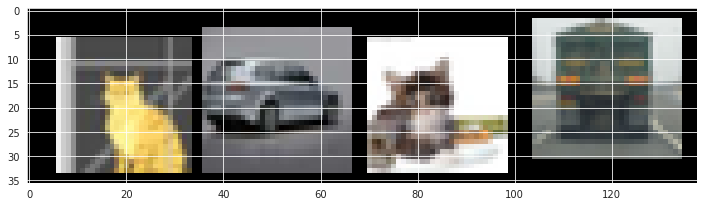

In [6]:
def imshow(img):
    npimg = img.numpy()
    norm_img = (npimg - np.min(npimg))/(np.max(npimg) - np.min(npimg)) # min-max normalization
    fig = plt.figure()
    fig.set_size_inches([12, 6])
    plt.imshow(np.transpose(norm_img, (1, 2, 0)))

# get some random training images
data_iterator = iter(trainloader)
images, labels = data_iterator.next()

imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join('%17s' % classes[labels[j]] for j in range(4))) # print labels
plt.show()

0it [00:00, ?it/s]

100%|█████████▉| 170385408/170498071 [02:11<00:00, 1040798.81it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
            horse               cat             plane               cat


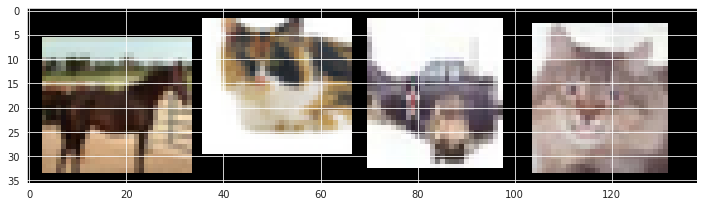

In [11]:
trainloader, testloader, classes, img_shape = get_data(CIFAR10=True, batch_size=4, 
                                                       proportion=0.1)

# get some random training images
data_iterator = iter(trainloader)
images, labels = data_iterator.next()

imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join('%17s' % classes[labels[j]] for j in range(4))) # print labels
plt.show()

In [12]:
# # CIFAR10=False => MNIST
# trainloader, testloader, classs, img_shape = get_data(CIFAR10=False, batch_size=64, 
#                                                       proportion=0.1)
# img_channels = img_shape[2]
# img_shape

In [13]:
images.shape

torch.Size([4, 3, 32, 32])

### Part (a) - Logistic Regression

**Fully connected output, $0$ hidden layers (logistic regression):** 

We begin with the simplest network possible that has no hidden layers and simply linearly maps the input layer to the output layer. That is, conceptually it could be written as

$$ x^{out} = W\cdot \text{vec}(x^{in}) + b $$

where $x^{out} \in \mathbb{R}^{10}$, $x^{in} \in \mathbb{R}^{32 \times 32 \times 3}$, $W \in \mathbb{R}^{10, 3072}$, $b \in \mathbb{R}^{10}$ where $3072 = 32 \cdot 32 \cdot 3$. For a tensor $x \in \mathbb{R}^{a \times b \times c}$, we let vec$(x) \in \mathbb{R}^{abc}$ be the reshaped from a tensor into a vector (in an arbitrary but consistent pattern).

#### Model for part (a)

Define model architecture

In [14]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(32*32*img_channels, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*img_channels)
        out = self.linear(x)
        return out

Compile model

In [15]:
#lr_net = LinearRegression().cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr_net = LinearRegression().to(device)

In [16]:
device

device(type='cuda', index=0)

Choose Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lr_net.parameters(), lr=0.001, momentum=0.9)

170500096it [02:30, 1040798.81it/s]                               

Train + Evaluate concurrently

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_accuracy, test_accuracy, loss_list = [], [], []
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs       
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = lr_net(inputs)
        loss = criterion(outputs, labels)
      
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
     
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lr_net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))       
print('Finished Training')

Accuracy of the network on the 10000 test images: 23 %
Finished Training


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = lr_net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 45 %
Accuracy of   car : 36 %
Accuracy of  bird : 27 %
Accuracy of   cat : 37 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog : 36 %
Accuracy of horse : 41 %
Accuracy of  ship :  2 %
Accuracy of truck : 31 %


In [20]:
def class_accuracies(dataloader, model):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

**The training stage can be abstracted.** Notice (almost) nothing is hardcoded to the specific task.

In [21]:
def evaluate(dataloader, model, device):
    correct, total = 0, 0 
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return correct/total

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

        
        
def train(model, trainloader, testloader, criterion, optimizer, device, 
          epochs=1, weight_decay=False, print_freq=1):
    
    train_accuracy, test_accuracy, loss_list = [], [], []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # wrap the inputs       
            inputs, labels = inputs.to(device), labels.to(device)
      
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Decay learning rate
        if weight_decay and (epoch+1) % 20 == 0:
            curr_lr /= 3
            update_lr(optimizer, curr_lr)
        
        if epoch % print_freq == 0:
            train_acc = evaluate(trainloader, model, device) 
            train_accuracy.append(train_acc)

            test_acc = evaluate(testloader, model, device)
            test_accuracy.append(test_acc)
            loss_list.append(loss.item())
        
            print('[Epoch %2d ||  Train acc: %d %% | Test acc: %d %% | loss: %.3f ]' 
                              % (epoch, train_acc*100, test_acc*100, 
                                 running_loss/(len(trainloader))))

    print('Finished Training')
    return model, train_accuracy, test_accuracy, loss_list

Train `lr_net` again:

In [22]:
torch.cuda.is_available()

True

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr_net = LinearRegression().to(device)

In [24]:
device

device(type='cuda', index=0)

In [25]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lr_net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import time
start = time.time()

lr_net, train_acc, test_acc, losses = train(lr_net, trainloader, testloader,
                                            criterion, optimizer, device, 
                                            epochs=10, print_freq=1)

end = time.time()
print('%.1f seconds' % (end - start))

[Epoch  0 ||  Train acc: 24 % | Test acc: 23 % | loss: 2.433 ]


In [21]:
def plot_acc(train_acc, test_acc, losses, save=False, outfile='img.plt'):
    fig = plt.figure()
    fig.set_size_inches([12, 6])
    
    plt.plot(train_acc, 'y', alpha = 0.5, label = 'Training Accuracy')
    plt.plot(test_acc, 'r', alpha = 0.5, label = 'Testing Accuracy')
    plt.plot(losses/np.max(losses), 'g', alpha = 0.5, label = 'Loss')
    plt.ylabel('Accuracy'); plt.xlabel('Interations')
    plt.ylim(0, plt.ylim()[1]); plt.ylim(0, 1)
    
    plt.legend()
    if save:
        plt.savefig(outfile)
    plt.show()

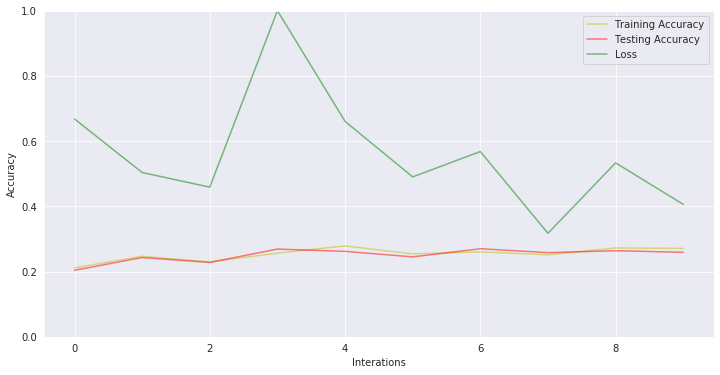

In [22]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='lr_net.png')

In [ ]:
class_accuracies(testloader, lr_net)

### Part (b) - MLP

Fully connected output, 1 fully connected hidden layer: we will have one hidden layer denoted as $x^{hidden} \in \mathbb{R}^M$ where $M$ will be a hyperparameter you choose ($M$ could be in the hundreds). The nonlinearity applied to the hidden layer will be the relu (relu$(x) = \max\{0, x\}$, elementwise). Conceptually, one could write this network as:

$$ x^{out} = W_2\text{relu}(W_1\text{vec}(x^{in}) + b_1) + b_2$$

where $W_1 \in \mathbb{R}^{M \times 3072}, b_1 \in \mathbb{R}^M, W_2 \in \mathbb{R}^{10 \times M}, b_2 \in \mathbb{R}^{10}$.

In [ ]:
# choose the number of hidden layers
M = 128

In [ ]:
class OneHidden(nn.Module):
    def __init__(self):
        super(OneHidden, self).__init__()
        self.fc1 = nn.Linear(np.prod(img_shape), M)
        self.fc2 = nn.Linear(M, 10)

    def forward(self, x):
        x = x.view(-1, np.prod(img_shape))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
one_hidden_net = OneHidden().to(device)

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(one_hidden_net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [ ]:
start = time.time()
one_hidden_net, train_acc, test_acc, losses = train(one_hidden_net, trainloader, testloader,
                                           criterion, optimizer, device=device,
                                           epochs=15, print_freq=1)
end = time.time()
print('%.1f seconds' % (end - start))

In [ ]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='one_hidden_net.png')

In [ ]:
class_accuracies(testloader, one_hidden_net)

### Part (c) - Simple Conv Net


Fully connected output, 1 convolutional layer with max-pool: for a convolutional layer $W_1$ with individual filters of size $p \times p \times 3$ and output size $M$ (reasonable choices are $M = 100, p = 5$) we have that Conv2d$(x^{input}, W_1) \in \mathbb{R}^{(33 - p)\times (33 - p) \times M}$. 

Each convolution will have its own offset applied to each of the output pixels of the convolution; we denote this as Conv2d$(x^{input}, W) + b_1$ where $b_1$ is parameterized in $\mathbb{R}^M$. We will then apply a relu (relu doesn't change the tensor space) and pool. If we use a max-pool of size $N$ (a reasonable choice is $N = 14$ to pool to $2 \times 2$ with $p = 5$) we have that 

$$ \text{MaxPool(relu(Conv2d}(x^{input}, W_1) + b_1)) \in \mathbb{R}^{\lfloor \frac{33-p}{N} \rfloor \times \lfloor \frac{33- p}{N} \rfloor \times M}.$$

We will then apply a fully connected layer to the output to get the final network given as

$$ x^{out} = W_2\text{vec}(\text{MaxPool}(\text{relu}(\text{Conv2d}(x^{in}, W_1) + b_1))) + b_2$$

where $W_2 \in \mathbb{R}^{10 \times M(\lfloor \frac{33-p}{N} \rfloor)^2}, b_2 \in \mathbb{R}^{10}$. The parameters $M, p, N$ (in addition to the step size and the momentum are all hyperparameters.

In [ ]:
p = 5 # size of filters
M = 100 # number of filters
N = 14 # pooling size
input_size = img_shape[0]
output_size = 10
channel_nb = img_shape[2] # i.e. RGB
floor_divide = np.floor_divide(input_size + 1 - p, N) # this is floor(28/14) = 2

class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv1 = nn.Conv2d(channel_nb, M, p) ## 6x28x28, where 28 = 33-5
        self.pool = nn.MaxPool2d(N, N) ## 6 x 14 x 14
        self.fc1 = nn.Linear(M * floor_divide * floor_divide, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, M * floor_divide * floor_divide)
        x = self.fc1(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
one_conv_net = OneConv().to(device)

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(one_conv_net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [ ]:
start = time.time()
one_conv_net, train_acc, test_acc, losses = train(one_conv_net, trainloader, testloader,
                                           criterion, optimizer, device=device,
                                           epochs=30, print_freq=1)
end = time.time()
print('%.1f seconds' % (end - start))

In [ ]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='one_conv_net.png')

In [ ]:
class_accuracies(testloader, one_conv_net)

### Part (d)

We will return to the original network you were left with at the end of the tutorial Training a classifier, tune the different hyperparameters (number of convolutional filters, filter sizes, dimensionality of the fully connected layers, stepsize, etc.) and train for many epochs to achieve a test accuracy of at least 85%.

##### Model

In [ ]:
conv_size1 = 5 
conv_size2 = 3
num_hidden_nodes = 128 ## 
N = 2
input_size = img_shape[0]
output_size = 10
channel_nb = img_shape[2]
pool_size = 2


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # input (32, 32, 3)
        self.conv1 = nn.Conv2d(channel_nb, num_hidden_nodes, conv_size1, padding = 2) 
        # input (32, 32, 128)
        self.pool = nn.MaxPool2d(2, 2) 
        # input (16, 16, 128)
        self.conv2 = nn.Conv2d(num_hidden_nodes, 256, 3, padding = 1) 
        # pool
        # input (8, 8, 256)
        self.conv3 = nn.Conv2d(256, 512, 3, padding = 1) 
        # pool
        # input (4, 4, 512)
        self.fc1 = nn.Linear(512 * 4 * 4, 2048) 
        # input (2048)
        self.fc2 = nn.Linear(2048, 256)
        # input (256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 512 * 4 * 4) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
conv_net = ConvNet().to(device)

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [ ]:
start = time.time() # 22 min on 1080 Ti

conv_net, train_acc, test_acc, losses = train(conv_net, trainloader, testloader,
                                           criterion, optimizer, device=device,
                                           epochs=30, print_freq=1)

end = time.time()
print('%.1f seconds' % (end - start))

In [ ]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='conv_net.png')

##### Accuracy on particular classes

In [ ]:
class_accuracies(testloader, conv_net)

In [ ]:
test_acc = evaluate(testloader, conv_net, device)
test_acc

# ResNet

In [ ]:
class ResNetFull(nn.Module):
    def __init__(self):
        super(ResNetFull, self).__init__()
        self.conv1 = nn.Conv2d(img_shape[2],16,kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        # layer 1
        # block 1      
        self.conv1_blck1_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn1_blck1_lyr1 = nn.BatchNorm2d(16)
        self.relu_blck1_lyr1 = nn.ReLU(inplace=True)
        self.conv2_blck1_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn2_blck1_lyr1 = nn.BatchNorm2d(16)
        
        # block 2
        self.conv1_blck2_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn1_blck2_lyr1 = nn.BatchNorm2d(16)
        self.relu_blck2_lyr1 = nn.ReLU(inplace=True)
        self.conv2_blck2_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn2_blck2_lyr1 = nn.BatchNorm2d(16)
        
        # block 3
        self.conv1_blck3_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn1_blck3_lyr1 = nn.BatchNorm2d(16)
        self.relu_blck3_lyr1 = nn.ReLU(inplace=True)
        self.conv2_blck3_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn2_blck3_lyr1 = nn.BatchNorm2d(16)
        
        # layer 2
        self.downsample1 = nn.Sequential(nn.Conv2d(16, 32, stride=2, kernel_size=3, 
                                        padding=1, bias=False), nn.BatchNorm2d(32))
        
        self.conv1_blck1_lyr2 = nn.Conv2d(32,32,kernel_size=3, padding=1, bias=False)
        self.bn1_blck1_lyr2 = nn.BatchNorm2d(32)
        self.relu_blck1_lyr2 = nn.ReLU(inplace=True)
        self.conv2_blck1_lyr2 = nn.Conv2d(32,32,kernel_size=3, padding=1, bias=False)
        self.bn2_blck1_lyr2 = nn.BatchNorm2d(32)
        
        self.conv1_blck2_lyr2 = nn.Conv2d(32,32,kernel_size=3, padding=1, bias=False)
        self.bn1_blck2_lyr2 = nn.BatchNorm2d(32)
        self.relu_blck2_lyr2 = nn.ReLU(inplace=True)
        self.conv2_blck2_lyr2 = nn.Conv2d(32,32,kernel_size=3, padding=1, bias=False)
        self.bn2_blck2_lyr2 = nn.BatchNorm2d(32)
        
        # layer 3
        self.downsample2 = nn.Sequential(nn.Conv2d(32, 64, stride=2, kernel_size=3, 
                                        padding=1, bias=False),nn.BatchNorm2d(64))
        self.conv1_blck1_lyr3 = nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False)
        self.bn1_blck1_lyr3 = nn.BatchNorm2d(64)
        self.relu_blck1_lyr3 = nn.ReLU(inplace=True)
        self.conv2_blck1_lyr3 = nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False)
        self.bn2_blck1_lyr3 =nn.BatchNorm2d(64)
        
        self.conv1_blck2_lyr3 = nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False)
        self.bn1_blck2_lyr3 = nn.BatchNorm2d(64)
        self.relu_blck2_lyr3 = nn.ReLU(inplace=True)
        self.conv2_blck2_lyr3 = nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False)
        self.bn2_blck2_lyr3 = nn.BatchNorm2d(64)
        
        self.avg_pool = nn.AvgPool2d(8) 
        self.fc1 = nn.Linear(64 * 1 * 1, 10)
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        
        ## layer 1
        # block 1
        residual = out
        out = self.conv1_blck1_lyr1(out)
        out = self.bn1_blck1_lyr1(out)
        out = self.relu_blck1_lyr1(out)
        out = self.conv2_blck1_lyr1(out)
        out = self.bn2_blck1_lyr1(out)
        out += residual
        
        # block 2
        residual = out
        out = self.conv1_blck2_lyr1(out)
        out = self.bn1_blck2_lyr1(out)
        out = self.relu_blck2_lyr1(out)
        out = self.conv2_blck2_lyr1(out)
        out = self.bn2_blck2_lyr1(out)
        out += residual
        
        # block 3
        residual = out
        out = self.conv1_blck3_lyr1(out)
        out = self.bn1_blck3_lyr1(out)
        out = self.relu_blck3_lyr1(out)
        out = self.conv2_blck3_lyr1(out)
        out = self.bn2_blck3_lyr1(out)
        out += residual
        

        ## layer 2
        # block 1
        residual = self.downsample1(out)
        out = self.downsample1(out) # downsample
        out = self.conv1_blck1_lyr2(out)
        out = self.bn1_blck1_lyr2(out)
        out = self.relu_blck1_lyr2(out)
        out = self.conv2_blck1_lyr2(out)
        out = self.bn2_blck1_lyr2(out)
        out += residual
        
        # block 2
        residual = out
        out = self.conv1_blck2_lyr2(out)
        out = self.bn1_blck2_lyr2(out)
        out = self.relu_blck2_lyr2(out)
        out = self.conv2_blck2_lyr2(out)
        out = self.bn2_blck2_lyr2(out)
        out += residual


        ## layer 3
        # block 1
        residual = self.downsample2(out)
        out = self.downsample2(out) # downsample
        out = self.conv1_blck1_lyr3(out)
        out = self.bn1_blck1_lyr3(out)
        out = self.relu_blck1_lyr3(out)
        out = self.conv2_blck1_lyr3(out)
        out = self.bn2_blck1_lyr3(out)
        out += residual
        
        # block 2
        residual = out
        out = self.conv1_blck2_lyr3(out)
        out = self.bn1_blck2_lyr3(out)
        out = self.relu_blck2_lyr3(out)
        out = self.conv2_blck2_lyr3(out)
        out = self.bn2_blck2_lyr3(out)
        out += residual
        
        out = self.avg_pool(out)
        out = out.view(-1, 1*1*64)
        out = self.fc1(out)
        return out

In [ ]:
fullnet = ResNetFull().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fullnet.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(fullnet.parameters(), betas = (0.9, 0.999))

In [ ]:
start = time.time() 

fullnet, train_acc, test_acc, losses = train(fullnet, trainloader, testloader,
                                           criterion, optimizer, device=device,
                                           epochs=35, print_freq=1)

end = time.time()
print('%.1f seconds' % (end - start))

In [ ]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='res_net.png')

In [ ]:
class_accuracies(testloader, fullnet)

## ResNet, cleaner

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(img_shape[2], 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
resnet = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [ ]:
resnet, train_acc, test_acc, losses = train(resnet, trainloader, testloader,
                                           criterion, optimizer, epochs=120, weight_decay=True, device=device)

In [ ]:
plot_acc(train_acc, test_acc, losses)

# MobilenetV2

In [24]:
from torch import nn
# from utils import load_state_dict_from_url


__all__ = ['MobileNetV2', 'mobilenet_v2']


model_urls = {
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
}


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self,
                 num_classes=1000,
                 width_mult=1.0,
                 inverted_residual_setting=None,
                 round_nearest=8,
                 block=None):
        """
        MobileNet V2 main class
        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x):
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)

In [25]:
def mobilenet_v2(pretrained=True):
    model = MobileNetV2(width_mult=1)

#     if pretrained:
#         try:
#             from torch.hub import load_state_dict_from_url
#         except ImportError:
#             from torch.utils.model_zoo import load_url as load_state_dict_from_url
#         state_dict = load_state_dict_from_url(
#             'https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1', progress=True)
#         model.load_state_dict(state_dict)
    return model

In [27]:
import torch
model = torch.hub.load('pytorch/vision:v0.5.0', 'mobilenet_v2', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /home/nknuecht/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/nknuecht/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 18.5MB/s]


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [28]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [29]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

tensor([ 2.0977e+00, -1.7348e+00, -2.2355e+00, -2.9669e+00, -2.3805e+00,
         9.7397e-01, -1.6049e+00,  3.6914e+00,  6.3812e+00, -1.2929e+00,
        -6.7555e+00, -3.3525e+00, -7.9619e+00, -4.4554e+00, -5.6423e+00,
        -4.6624e+00, -1.9577e+00, -3.5811e-01, -1.2812e+00, -4.6707e+00,
        -3.2935e+00, -2.5674e+00, -2.4351e+00, -1.3017e+00, -3.2453e+00,
        -1.4237e+00, -1.2001e+00,  4.1275e-01, -1.6093e+00,  1.5871e+00,
         2.7725e-01, -6.2652e-01, -2.9734e-01, -3.8219e+00, -1.5450e+00,
        -2.8976e+00, -5.6528e-01, -2.3938e+00, -3.3705e-01,  1.2809e+00,
        -1.2516e+00, -2.6469e+00, -3.1011e+00, -2.2447e+00, -4.4385e-01,
        -1.2620e+00,  8.2896e-01, -2.0436e+00, -6.6036e-01, -8.6518e-02,
         4.8967e-01, -1.7190e+00, -7.7943e-01, -1.1046e+00, -5.3857e-01,
        -2.9254e+00, -1.9327e+00, -2.7273e+00, -6.0903e-01, -1.6802e+00,
         1.3443e+00, -4.2062e+00, -1.4768e+00, -4.5581e+00, -3.2726e+00,
        -4.0086e+00,  1.5702e-01, -1.9921e+00, -7.4